# Sentiment analysis with deep learning: 
1. ### Recurrent Neural Network; 
2. ### Long Short Term Memory

In [1]:
import pandas as pd 
from src.data_processing import Text_processor

df = pd.read_csv("tripadvisor_hotel_reviews.csv")

# convert the continous rating variable to discrete categories
df["label"] = df["Rating"].apply(Text_processor.labelling)
df.head(10)

2024-02-04 17:50:15.237867: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-04 17:50:15.275832: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 17:50:15.275858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 17:50:15.276848: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-04 17:50:15.282611: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-04 17:50:15.283089: I tensorflow/core/platform/cpu_feature_guard.cc:1

,Review,Rating,label
0,nice hotel expensive parking got good deal sta...,4,Positive
1,ok nothing special charge diamond member hilto...,2,Negative
2,nice rooms not 4* experience hotel monaco seat...,3,Neutral
3,"unique, great stay, wonderful time hotel monac...",5,Positive
4,"great stay great stay, went seahawk game aweso...",5,Positive
5,love monaco staff husband stayed hotel crazy w...,5,Positive
6,"cozy stay rainy city, husband spent 7 nights m...",5,Positive
7,"excellent staff, housekeeping quality hotel ch...",4,Positive
8,"hotel stayed hotel monaco cruise, rooms genero...",5,Positive
9,excellent stayed hotel monaco past w/e delight...,5,Positive


### Exploratory Data Analysis
In this section some preliminary analysis on the dataset feature and on the its variables will be carried out: 
1. plots will be saved in the plot folder; 
2. Summary statistics will be saved in the EDA.txt file

In [2]:
from src.EDA import EDA

eda = EDA(df)

eda_file = 'EDA.txt'
review = 'Review'
rating = 'label'

# Information about the dataset 
eda.dataset_info(eda_file)
# information about the label colum
eda.summary_statistics(rating, eda_file)
# Investigating possible relationships between reviews lenght and the rating
eda.variables_relationship(review, rating, eda_file)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
 2   label   20491 non-null  object
dtypes: int64(1), object(2)
memory usage: 480.4+ KB
Plot saved at: /home/ziyangfu/Code/Sentiment_Analysis_Models_Comparison/src/../plot/summary_statistics_label.html
Plot saved at: /home/ziyangfu/Code/Sentiment_Analysis_Models_Comparison/src/../plot/summary_statistics_reviews_lenght.html
Plot saved at: /home/ziyangfu/Code/Sentiment_Analysis_Models_Comparison/src/../plot/scatterplot.html


### Text processing: 
prepare and clean the text data before feeding it into a sentiment analysis model. These are the step through which the reviews will undergo: 
1. Text Lowercasing;
2. Tokenization: break the text into individual words or tokens;
3. Removing Punctuation and Stopwords; 
4. Lemmatization:reduce words to their root or base form; 
5. TF-IDF Vectorization: represent each review as a vector based on the importance of words. 

In [3]:
import numpy as np

num_parts = 4
df_chunks = np.array_split(df, num_parts)

cleaned_df = Text_processor.parallel_text_cleaning(df_chunks)
cleaned_df.head(10)

/home/ziyangfu/Code/Sentiment_Analysis_Models_Comparison/Sentiment/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.



Chunk 2 has been processed
Chunk 1 has been processed
Chunk 0 has been processed
Chunk 3 has been processed


,Review,Rating,label,reviews_lenght
0,nice hotel expensive park get good deal stay h...,4,Positive,593
1,ok nothing special charge diamond member hilto...,2,Negative,1689
2,nice room 4 experience hotel monaco seattle go...,3,Neutral,1427
3,unique great stay wonderful time hotel monaco ...,5,Positive,600
4,great stay great stay go seahawk game awesome ...,5,Positive,1281
5,love monaco staff husband stay hotel crazy wee...,5,Positive,1002
6,cozy stay rainy city husband spend 7 nights mo...,5,Positive,748
7,excellent staff housekeep quality hotel chock ...,4,Positive,597
8,hotel stay hotel monaco cruise room generous d...,5,Positive,419
9,excellent stay hotel monaco past delight recep...,5,Positive,271


### Word Embeddings: feed pretrained word embeddings as vectors to our deep learning models

In [4]:
# Importing pretrained word embeddings

import requests
import zipfile

#url = "http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip" 
#response = requests.get(url)

#with open("glove.6B.zip", "wb") as f:
    #f.write(response.content)

zip_file_path = "glove.6B.zip"
# directory where to extract the contents (current working directory)
extracted_dir = "."

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into the target directory
    zip_ref.extractall(extracted_dir)


words_embeddings = dict()
# Explicitly specify the encoding as 'utf-8'
with open('glove.6B.50d.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        line = line.split(' ')
        try:
            words_embeddings[line[0]] = np.array(line[1:], dtype=float)
        except Exception as e:
            # Print the exception for debugging purposes
            print(f"Error processing line: {line}. Exception: {e}")
            continue

In [5]:
from src.data_processing import Embeddings_processor

# mapping sentences to their respective embeddings 
embeddings_proc = Embeddings_processor(words_embeddings)
cleaned_df['Review'] = cleaned_df['Review'].apply(lambda x: embeddings_proc.word_vectors(x))

# fill empty sentences
for message in cleaned_df['Review']:
    if message.shape[0] == 0:
        message = np.zeros(shape=(1, 50))

# map the labels to integers for one-hot encoding 
label_mapping = {'Positive': 2, 'Negative': 0, "Neutral":1}
cleaned_df['label'] = cleaned_df['label'].map(label_mapping)

cleaned_df.head(10)


,Review,Rating,label,reviews_lenght
0,"[[0.20189, 0.80606, -1.1281, -0.59593, 0.52756...",4,2,593
1,"[[-0.53646, -0.072432, 0.24182, 0.099021, 0.18...",2,0,1689
2,"[[0.20189, 0.80606, -1.1281, -0.59593, 0.52756...",3,1,1427
3,"[[0.53801, 1.0704, -0.87108, 0.7013, 1.0154, 0...",5,2,600
4,"[[-0.026567, 1.3357, -1.028, -0.3729, 0.52012,...",5,2,1281
5,"[[-0.13886, 1.1401, -0.85212, -0.29212, 0.7553...",5,2,1002
6,"[[0.42559, 0.62546, -1.2205, 0.11198, 0.43133,...",5,2,748
7,"[[-0.40431, 0.78002, -0.67538, -0.097149, 0.54...",4,2,597
8,"[[1.6098, 1.0294, -0.50544, 0.40047, 0.38814, ...",5,2,419
9,"[[-0.40431, 0.78002, -0.67538, -0.097149, 0.54...",5,2,271


### Undersampling for classes' imbalance

In [6]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

# classes distribution 
counter_before = Counter(cleaned_df["label"])
print("Class distribution before undersampling:", counter_before)

# Undersample the majority classes
undersampler = RandomUnderSampler(random_state=42)

# Reshape the "Review" column to a 2D array
X = cleaned_df['Review'].values.reshape(-1, 1)

# Apply the undersampler
X_resampled, y_resampled = undersampler.fit_resample(X, cleaned_df["label"])

# Display class distribution after undersampling
counter_after = Counter(y_resampled)
print("Class distribution after undersampling:", counter_after)

Class distribution before undersampling: Counter({2: 15093, 0: 3214, 1: 2184})
Class distribution after undersampling: Counter({0: 2184, 1: 2184, 2: 2184})


In [7]:
# reshape back to its original form 
X_original_shape = X_resampled.reshape(-1,)


### Shuffle the all_sequences_vector and y_resampled
These 2 variables clusters in subsequent rows the observations belonging to the same class 

In [8]:
new_df = pd.DataFrame({
    'review_embedding': [embedding for embedding in X_original_shape],
    'label': y_resampled
})

print("pre-shuffled dataframe")
print(new_df.head(10))

shuffled_df = new_df.sample(frac=1, random_state=1)
shuffled_df.reset_index(drop=True, inplace=True)
print("post-shuffled dataframe")
print(shuffled_df.head(10))

pre-shuffled dataframe
                                    review_embedding  label
0  [[0.54623, 1.2042, -1.1288, -0.1325, 0.95529, ...      0
1  [[-0.026567, 1.3357, -1.028, -0.3729, 0.52012,...      0
2  [[-0.1166, -0.010887, 0.044444, -0.39349, 0.77...      0
3  [[0.80165, -0.36917, -0.38166, -0.090699, -0.4...      0
4  [[0.66845, -0.35565, 0.73838, -0.7142, 0.75459...      0
5  [[0.13409, 0.68926, 0.45086, 0.052204, -0.3060...      0
6  [[-0.53819, -0.40788, -0.1963, -0.80821, 0.077...      0
7  [[1.1303, 0.28035, 0.15825, -0.36373, 0.63884,...      0
8  [[0.23592, -0.073733, 0.21613, -0.57797, 0.147...      0
9  [[0.44285, 0.31399, 0.20969, -0.39017, 0.37531...      0
post-shuffled dataframe
                                    review_embedding  label
0  [[-0.88412, -0.072734, -0.8397, -0.12462, 0.74...      0
1  [[-0.32313, 0.89266, 0.54943, 0.59294, 0.56707...      0
2  [[0.4901, -0.060918, -0.28137, 0.49583, -0.311...      0
3  [[-0.026567, 1.3357, -1.028, -0.3729, 0.52012,... 

### Splitting into training, validation and test set 

In [9]:
X_shuffled = shuffled_df["review_embedding"].values
y_shuffled = shuffled_df["label"].values

embeddings_vectors  = [embedding for embedding in X_shuffled]

split_index_1 = int(len(embeddings_vectors) * 0.7)
split_index_2 = int(len(embeddings_vectors) * 0.85)
X_train, X_val, X_test = embeddings_vectors[:split_index_1], embeddings_vectors[split_index_1:split_index_2], embeddings_vectors[split_index_2:]
y_train, y_val, y_test = y_shuffled[:split_index_1], y_shuffled[split_index_1:split_index_2], y_shuffled[split_index_2:]

print(len(X_train), len(X_val), len(X_test))
print(len(y_train), len(y_val), len(y_test))


4586 983 983
4586 983 983


### Padding the input sentence arrays
Recurrent neural networks (RNNs) and their variants process input data sequentially. 

In these models, each time step typically corresponds to an element in the input sequence. 

To apply batch processing efficiently, all sequences within a batch must have the same length, requiring padding for shorter sequences.

In [10]:
# determine the maximum lenght of the input sequences

sequence_lengths = [len(sequence) for sequence in X_train]
max_length = max(sequence_lengths)
print(f"Sequences maximum lenght: {max_length}")

Sequences maximum lenght: 1807


In [11]:
# Padding X_train, X_val and X_test 
X_train = Embeddings_processor.vectors_padding(X_train, max_length)
X_val = Embeddings_processor.vectors_padding(X_val, max_length)
X_test  = Embeddings_processor.vectors_padding(X_test, max_length)

Padding Progress:   3%|▎         | 31/983 [00:00<00:06, 151.62it/s]


In [13]:
# One hot encode the labels 
enc_y_train, enc_y_val, enc_y_test = Embeddings_processor.label_encoder(y_train, y_val, y_test)

# Recurrent Neural Network

In [17]:
from src.deep_learning import RNN 

RNN_model = RNN(X_train, enc_y_train, X_val, enc_y_val, 
                X_test, enc_y_test)

RNN_model.model_training(15)
class_report, conf_matrix = RNN_model.model_evaluation(y_test)


Epoch 1/15


2024-02-04 18:38:14.703595: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1657380400 exceeds 10% of free system memory.


144/144 [==============================] - 24s 159ms/step - loss: 1.1028 - accuracy: 0.3312 - auc: 0.5021 - val_loss: 1.0994 - val_accuracy: 0.3479 - val_auc: 0.5110
Epoch 2/15
144/144 [==============================] - 26s 178ms/step - loss: 1.0999 - accuracy: 0.3360 - auc: 0.4983 - val_loss: 1.0994 - val_accuracy: 0.3377 - val_auc: 0.4981
Epoch 3/15
144/144 [==============================] - 31s 214ms/step - loss: 1.0992 - accuracy: 0.3362 - auc: 0.4983 - val_loss: 1.0988 - val_accuracy: 0.3388 - val_auc: 0.5053
Epoch 4/15
144/144 [==============================] - 31s 218ms/step - loss: 1.0988 - accuracy: 0.3341 - auc: 0.5021 - val_loss: 1.0979 - val_accuracy: 0.3469 - val_auc: 0.5163
Epoch 5/15
144/144 [==============================] - 26s 179ms/step - loss: 1.0982 - accuracy: 0.3384 - auc: 0.5102 - val_loss: 1.1022 - val_accuracy: 0.3042 - val_auc: 0.4901
Epoch 6/15
144/144 [==============================] - 26s 179ms/step - loss: 1.0997 - accuracy: 0.3345 - auc: 0.5015 - val_los

              precision    recall  f1-score   support

           0       0.33      1.00      0.50       326
           1       1.00      0.00      0.00       308
           2       1.00      0.00      0.01       349

    accuracy                           0.33       983
   macro avg       0.78      0.33      0.17       983
weighted avg       0.78      0.33      0.17       983



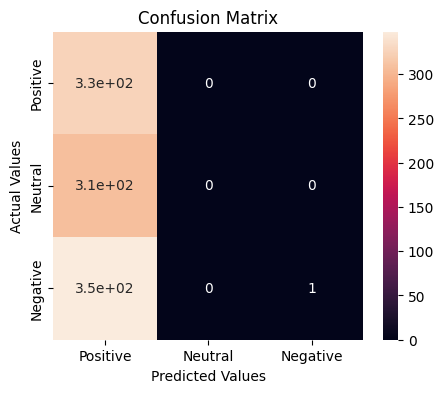

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

print(class_report)
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Long Short Term Memory

In [16]:
from src.deep_learning import LSTM 

LSTM_model = LSTM(X_train, enc_y_train, X_val, enc_y_val, 
                X_test, enc_y_test)

LSTM_model.model_training(15)
class_report, conf_matrix = LSTM_model.model_evaluation(y_test)

Epoch 1/15


2024-02-04 18:14:40.063387: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1657380400 exceeds 10% of free system memory.


144/144 [==============================] - 88s 599ms/step - loss: 1.0316 - accuracy: 0.4760 - auc: 0.6684 - val_loss: 0.9321 - val_accuracy: 0.5565 - val_auc: 0.7538
Epoch 2/15
144/144 [==============================] - 81s 561ms/step - loss: 0.8561 - accuracy: 0.5964 - auc: 0.7902 - val_loss: 0.8473 - val_accuracy: 0.5941 - val_auc: 0.7933
Epoch 3/15
144/144 [==============================] - 97s 678ms/step - loss: 0.7803 - accuracy: 0.6457 - auc: 0.8305 - val_loss: 0.8000 - val_accuracy: 0.6328 - val_auc: 0.8184
Epoch 4/15
144/144 [==============================] - 105s 732ms/step - loss: 0.7363 - accuracy: 0.6683 - auc: 0.8507 - val_loss: 0.7950 - val_accuracy: 0.6338 - val_auc: 0.8206
Epoch 5/15
144/144 [==============================] - 101s 702ms/step - loss: 0.7042 - accuracy: 0.6825 - auc: 0.8640 - val_loss: 0.7568 - val_accuracy: 0.6460 - val_auc: 0.8374
Epoch 6/15
144/144 [==============================] - 98s 684ms/step - loss: 0.6837 - accuracy: 0.6930 - auc: 0.8728 - val_l

              precision    recall  f1-score   support

           0       0.33      1.00      0.50       326
           1       1.00      0.00      0.00       308
           2       1.00      0.00      0.01       349

    accuracy                           0.33       983
   macro avg       0.78      0.33      0.17       983
weighted avg       0.78      0.33      0.17       983



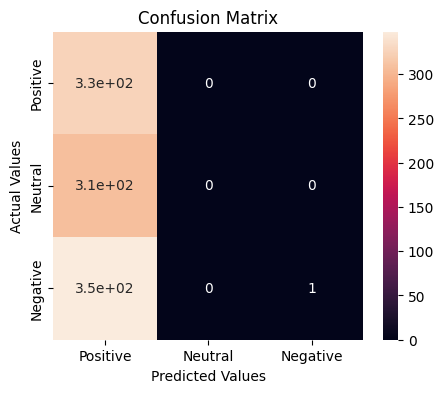

In [19]:
print(class_report)
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()